In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
"""Important imports"""
import glob

import torch

from polygen.modules.data_modules import PolygenDataModule, collate_vertex_model_batch, collate_face_model_batch
from polygen.modules.vertex_model import VertexModel
from polygen.modules.face_model import FaceModel
import polygen.utils.data_utils as data_utils


In [13]:
"""Get dataset ready"""
data_dir = "meshes/"
all_files = glob.glob(data_dir + "/*.obj")
label_dict = {}
for i, mesh_file in enumerate(all_files):
    label_dict[mesh_file] = i

vertex_data_module = PolygenDataModule(data_dir = data_dir, collate_fn = collate_vertex_model_batch, batch_size = 4,
                                        training_split = 1.0, val_split = 0.0, default_shapenet = False, all_files = all_files,
                                        label_dict = label_dict)

face_data_module = PolygenDataModule(data_dir = data_dir, collate_fn = collate_face_model_batch, batch_size = 4,
                                        training_split = 1.0, val_split = 0.0, default_shapenet = False, all_files = all_files,
                                        label_dict = label_dict)

vertex_data_module.setup()
face_data_module.setup()

vertex_dataloader = vertex_data_module.train_dataloader()
face_dataloader = face_data_module.train_dataloader()

vertex_batch = next(iter(vertex_dataloader))
face_batch = next(iter(face_dataloader))

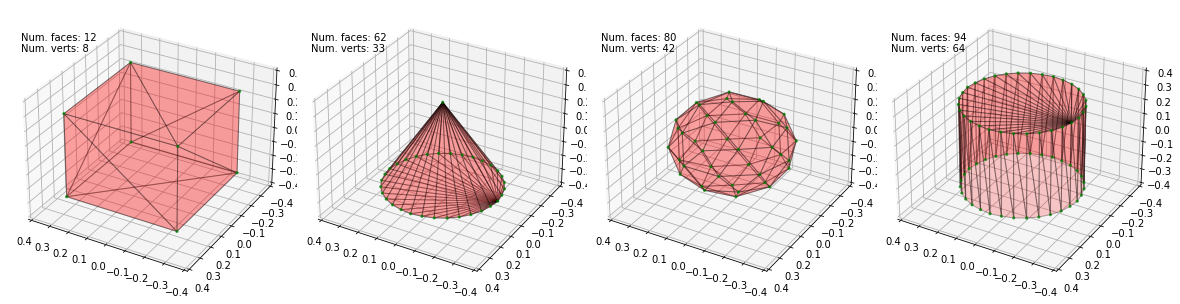

In [14]:
"""plot dataset"""
dataset = vertex_data_module.shapenet_dataset
mesh_list = []
for i in range(len(dataset)):
    mesh_dict = dataset[i]
    curr_verts, curr_faces = mesh_dict['vertices'], mesh_dict['faces']
    curr_verts = data_utils.dequantize_verts(curr_verts).numpy()
    curr_faces = data_utils.unflatten_faces(curr_faces.numpy())
    mesh_list.append({'vertices': curr_verts, 'faces': curr_faces})

data_utils.plot_meshes(mesh_list, ax_lims=0.4)

In [15]:
"""Load models"""
transformer_config = {
    "hidden_size": 128,
    "fc_size": 512,
    "num_layers": 3,
    "dropout_rate": 0.
}

vertex_model = VertexModel(decoder_config=transformer_config, class_conditional=True, num_classes=4,
                            max_num_input_verts=250, quantization_bits=8)

face_model = FaceModel(encoder_config=transformer_config, decoder_config=transformer_config, class_conditional=False,
                        max_seq_length=500, quantization_bits=8, decoder_cross_attention = True, use_discrete_vertex_embeddings=True)

In [16]:
def sample_and_plot(vertex_model, vertex_batch, face_model):
    with torch.no_grad():
        vertex_samples = vertex_model.sample(context = vertex_batch, num_samples = vertex_batch["class_label"].shape[0], max_sample_length = 200, 
                                        top_p = 0.95, recenter_verts = False, only_return_complete=False)
        max_vertices = torch.max(vertex_samples["num_vertices"]).item()
        vertex_samples["vertices"] = vertex_samples["vertices"][:, :max_vertices]
        vertex_samples["vertices_mask"] = vertex_samples["vertices_mask"][:, :max_vertices]
        face_samples = face_model.sample(context = vertex_samples, max_sample_length=500, top_p = 0.95, only_return_complete=False)
    mesh_list = []
    for i in range(vertex_samples["vertices"].shape[0]):
        num_vertices = vertex_samples["num_vertices"][i]
        vertices = vertex_samples["vertices"][i][:num_vertices].numpy()
        num_face_indices = face_samples['num_face_indices'][i]
        faces = data_utils.unflatten_faces(face_samples["faces"][i][:num_face_indices].numpy())
        mesh_list.append({'vertices': vertices, 'faces': faces})
    data_utils.plot_meshes(mesh_list, ax_lims = 0.5)

In [17]:
def sample_and_plot_vertices(vertex_model, vertex_batch):
    with torch.no_grad():
        vertex_samples = vertex_model.sample(context = vertex_batch, num_samples = vertex_batch["class_label"].shape[0],
                                            max_sample_length = 200, top_p = 0.95, recenter_verts = False, only_return_complete = False)
    
    mesh_list = []
    for i in range(vertex_samples["vertices"].shape[0]):
        num_vertices = vertex_samples["num_vertices"][i]
        vertices = vertex_samples["vertices"][i][:num_vertices].numpy()
        mesh_list.append({'vertices': vertices})
    
    data_utils.plot_meshes(mesh_list, ax_lims = 0.5)

In [18]:
def sample_and_plot_faces(face_model, face_batch):
    with torch.no_grad():
        face_samples = face_model.sample(context = face_batch, max_sample_length = 500, top_p = 0.95, only_return_complete = False)
    mesh_list = []
    for i in range(face_samples["faces"].shape[0]):
        curr_faces = face_samples["faces"][i]
        num_face_indices = face_samples['num_face_indices'][i]
        curr_faces = data_utils.unflatten_faces(curr_faces[:num_face_indices].numpy())
        vertices = face_batch["vertices"][i].numpy()
        mesh_list.append({'vertices': vertices, 'faces': curr_faces})
    
    data_utils.plot_meshes(mesh_list, ax_lims = 0.5)

Epoch 100: Vertex loss = 687.137451171875, Face loss = 2210.318115234375


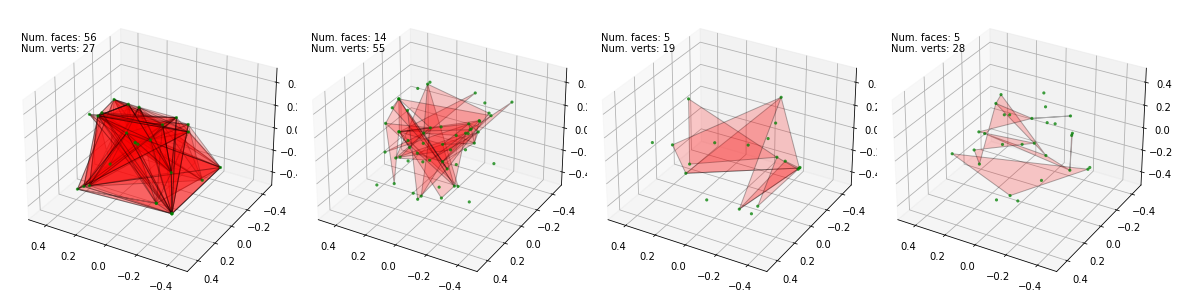

Epoch 200: Vertex loss = 50.77986145019531, Face loss = 421.5458068847656


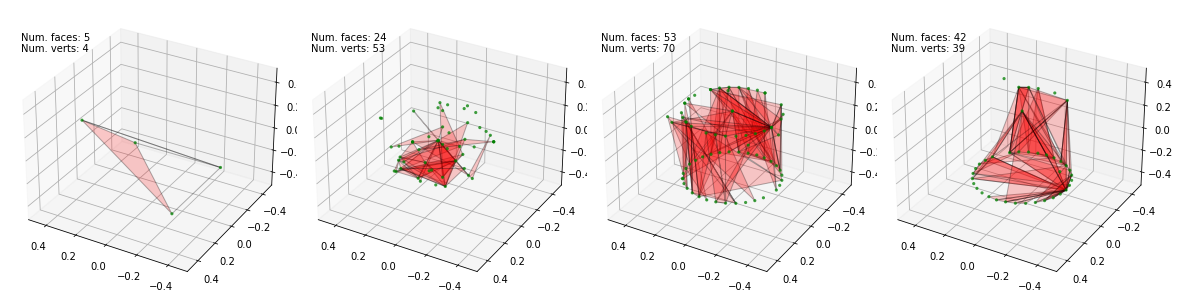

Epoch 300: Vertex loss = 11.13290786743164, Face loss = 37.01144790649414


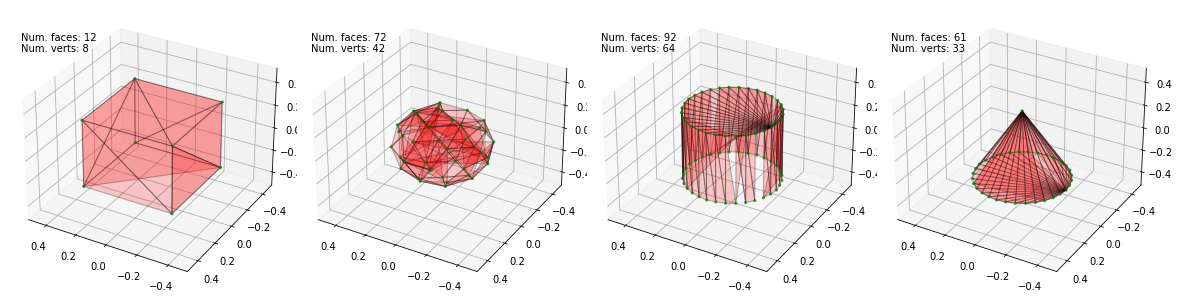

Epoch 400: Vertex loss = 4.528937339782715, Face loss = 10.321661949157715


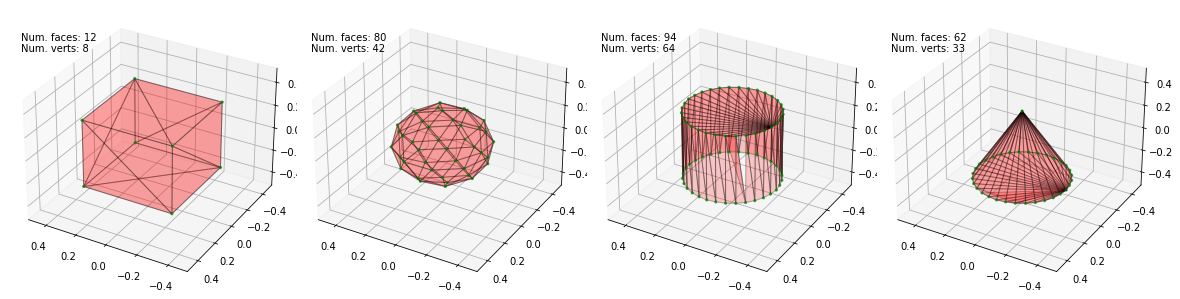

Epoch 500: Vertex loss = 7.8949055671691895, Face loss = 5.362340927124023


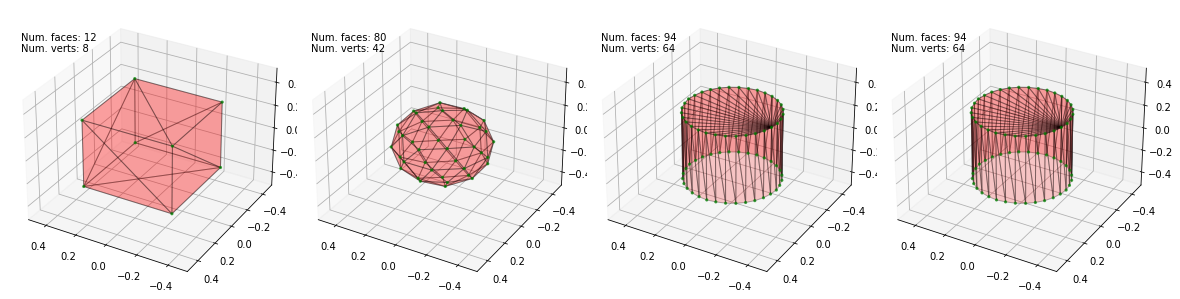

Epoch 600: Vertex loss = 2.7980222702026367, Face loss = 2.963469982147217


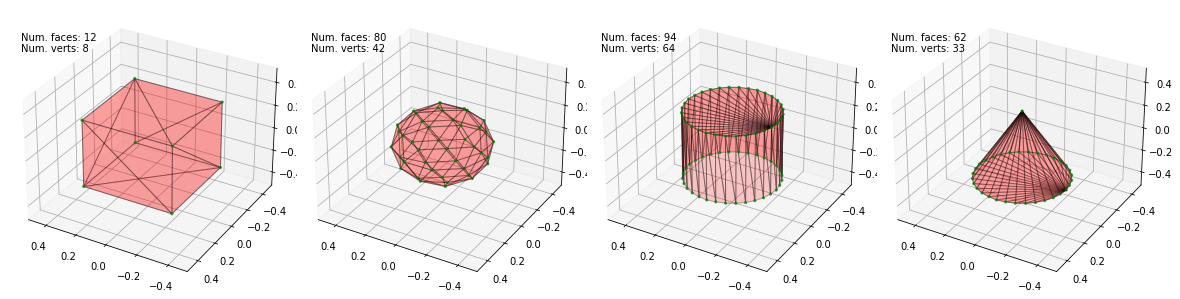

Epoch 700: Vertex loss = 1.5318403244018555, Face loss = 2.214056968688965


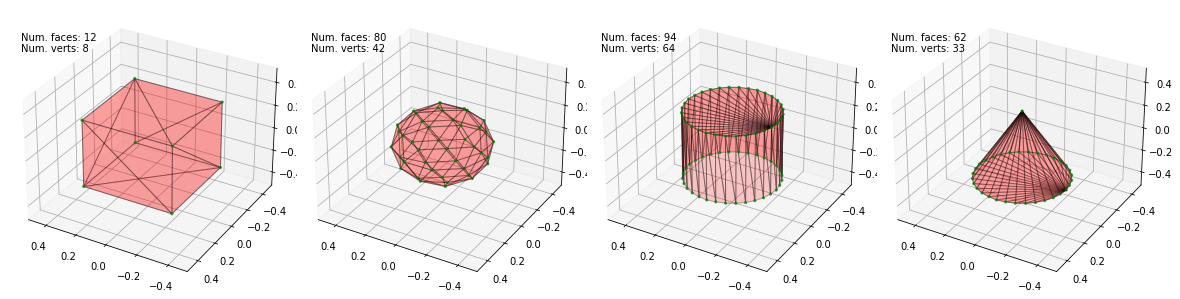

Epoch 800: Vertex loss = 1.0889177322387695, Face loss = 1.6174774169921875


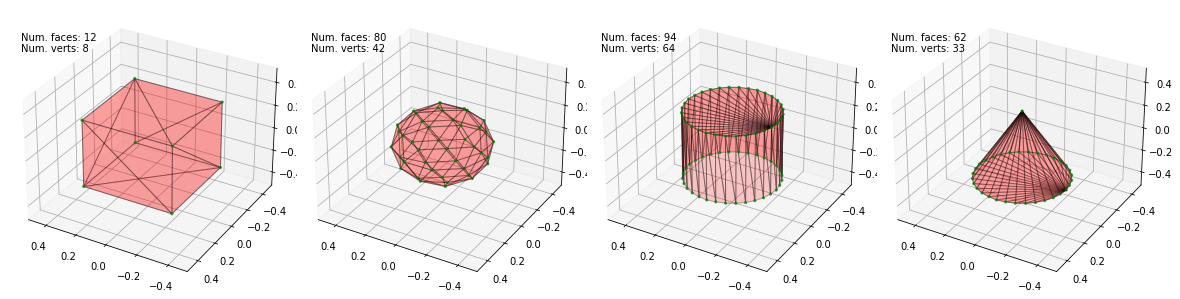

Epoch 900: Vertex loss = 0.8319387435913086, Face loss = 1.451181411743164


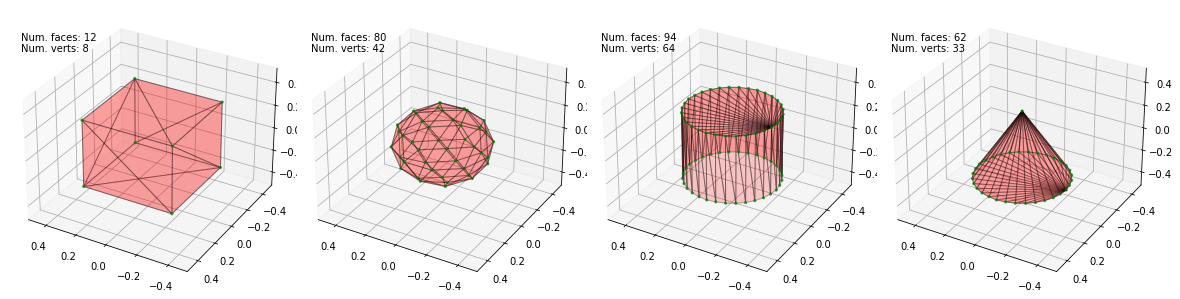

Epoch 1000: Vertex loss = 0.6703500747680664, Face loss = 9.07390308380127


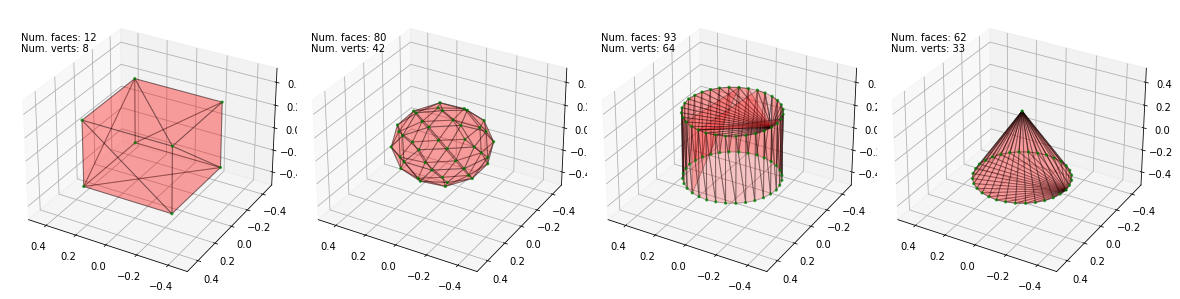

In [19]:
"""Joint Train Vertex and Face Model"""
epochs = 1000
vertex_model_optimizer = vertex_model.configure_optimizers()["optimizer"]
face_model_optimizer = face_model.configure_optimizers()["optimizer"]

for i in range(epochs):
    vertex_model_optimizer.zero_grad()
    face_model_optimizer.zero_grad()

    vertex_logits = vertex_model(vertex_batch)
    face_logits = face_model(face_batch)

    vertex_pred_dist = torch.distributions.categorical.Categorical(logits=vertex_logits)
    face_pred_dist = torch.distributions.categorical.Categorical(logits = face_logits)

    vertex_loss = -torch.sum(vertex_pred_dist.log_prob(vertex_batch["vertices_flat"]) * vertex_batch["vertices_flat_mask"])
    face_loss = -torch.sum(face_pred_dist.log_prob(face_batch["faces"])* face_batch["faces_mask"])

    vertex_loss.backward()
    face_loss.backward()

    vertex_model_optimizer.step()
    face_model_optimizer.step()

    if (i + 1) % 100 == 0:
        print(f"Epoch {i + 1}: Vertex loss = {vertex_loss.item()}, Face loss = {face_loss.item()}")
        sample_and_plot(vertex_model, vertex_batch, face_model)

/nethome/aahluwalia30/anaconda3/envs/polygen-env/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


Epoch 50: Vertex Loss = 1388.0240478515625


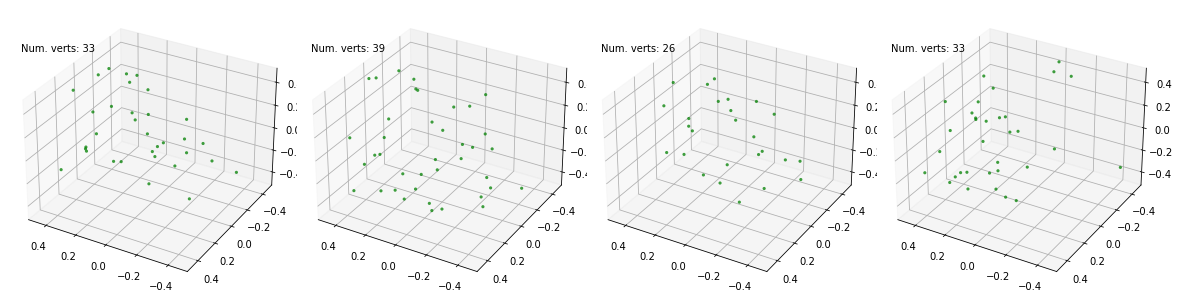

Epoch 100: Vertex Loss = 670.961181640625


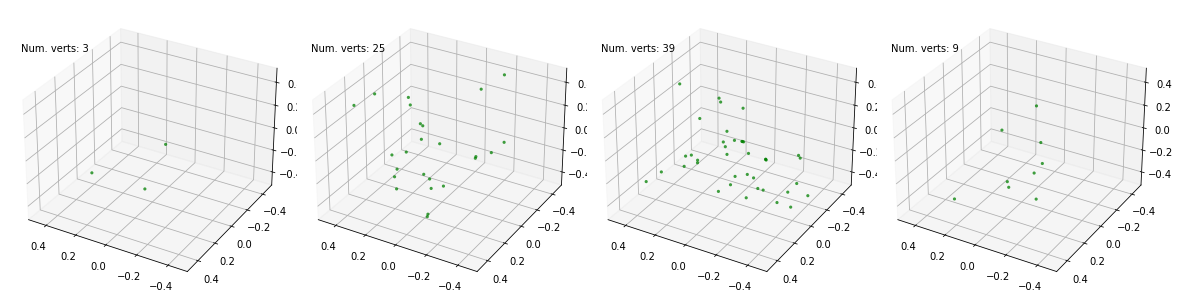

Epoch 150: Vertex Loss = 158.30490112304688


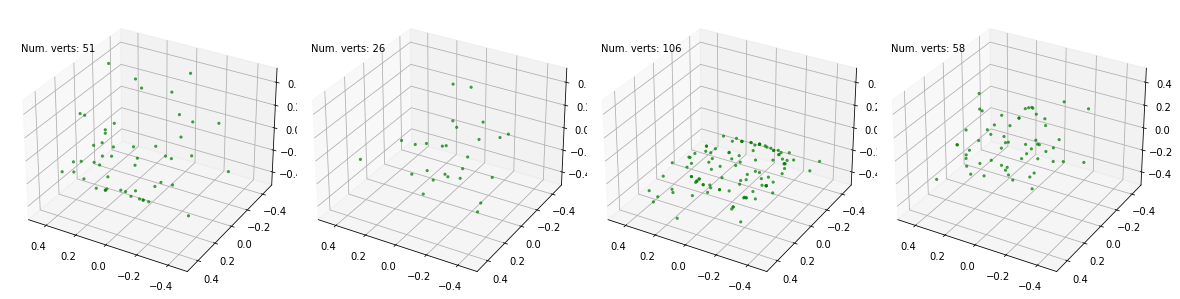

Epoch 200: Vertex Loss = 38.14124298095703


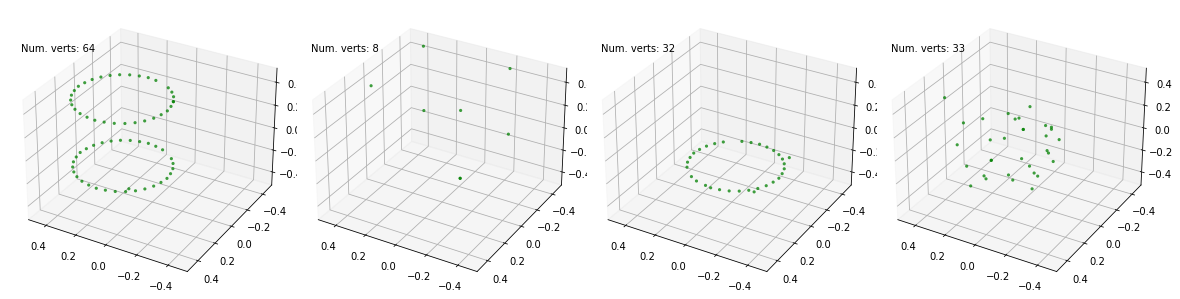

Epoch 250: Vertex Loss = 16.623430252075195


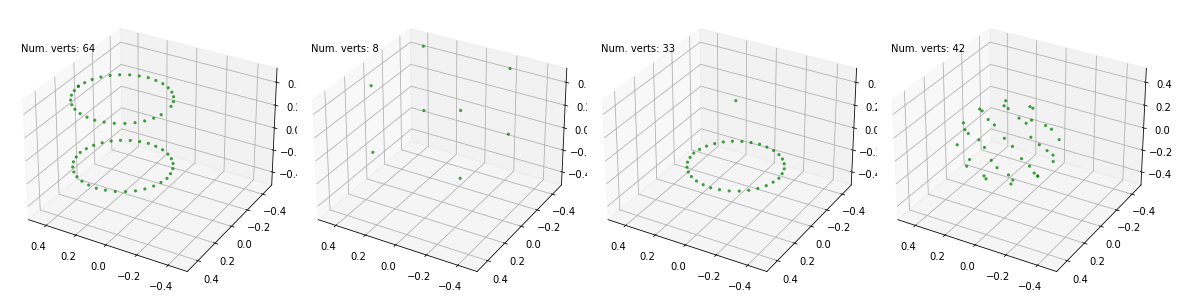

Epoch 300: Vertex Loss = 9.845157623291016


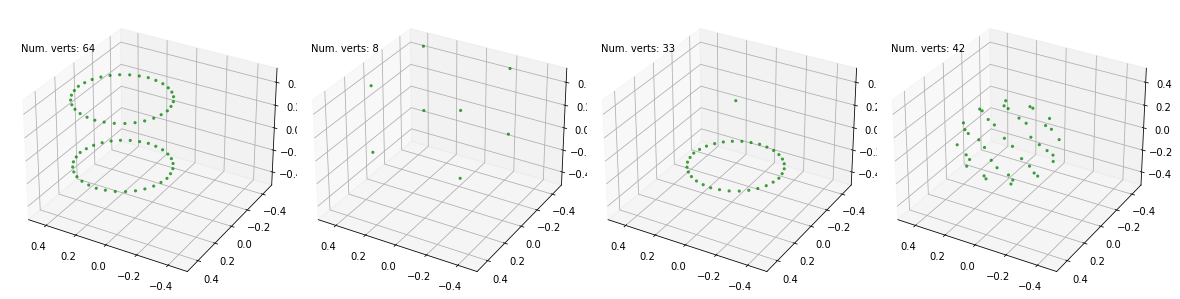

Epoch 350: Vertex Loss = 6.693045616149902


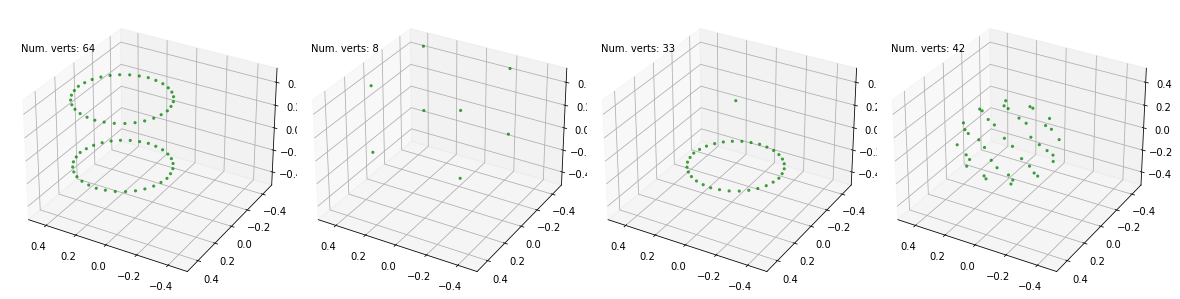

Epoch 400: Vertex Loss = 4.91285514831543


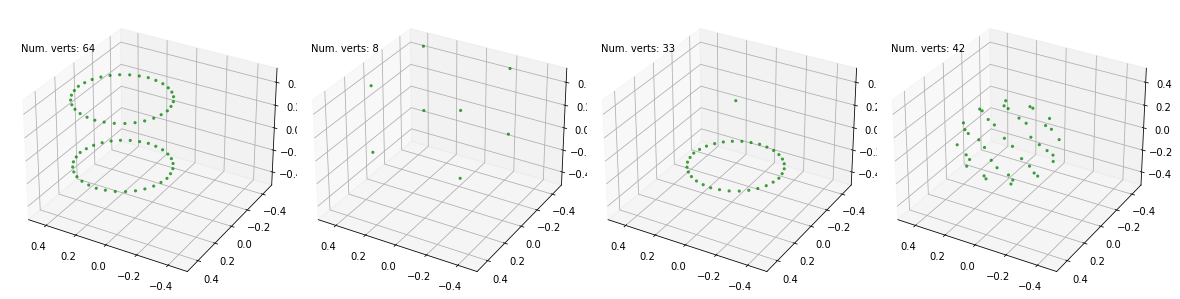

Epoch 450: Vertex Loss = 3.7918148040771484


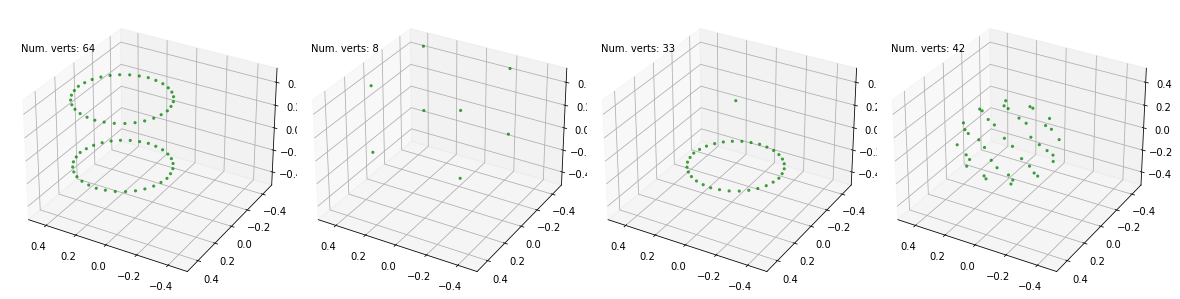

Epoch 500: Vertex Loss = 3.025454521179199


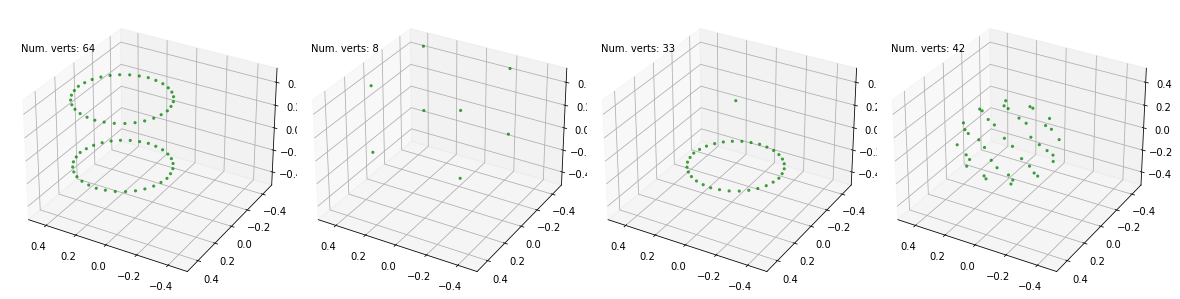

In [9]:
"""Train Vertex Model"""
epochs = 500
vertex_model_optimizer = vertex_model.configure_optimizers()["optimizer"]

for i in range(epochs):
    vertex_model_optimizer.zero_grad()
    vertex_logits = vertex_model(vertex_batch)
    vertex_pred_dist = torch.distributions.categorical.Categorical(logits=vertex_logits)
    vertex_loss = -torch.sum(vertex_pred_dist.log_prob(vertex_batch["vertices_flat"]) * vertex_batch["vertices_flat_mask"])
    vertex_loss.backward()
    vertex_model_optimizer.step()

    if (i + 1) % 50 == 0:
        print(f"Epoch {i + 1}: Vertex Loss = {vertex_loss.item()}")
        sample_and_plot_vertices(vertex_model, vertex_batch)
        

Epoch 50: Face Loss = 2930.8056640625


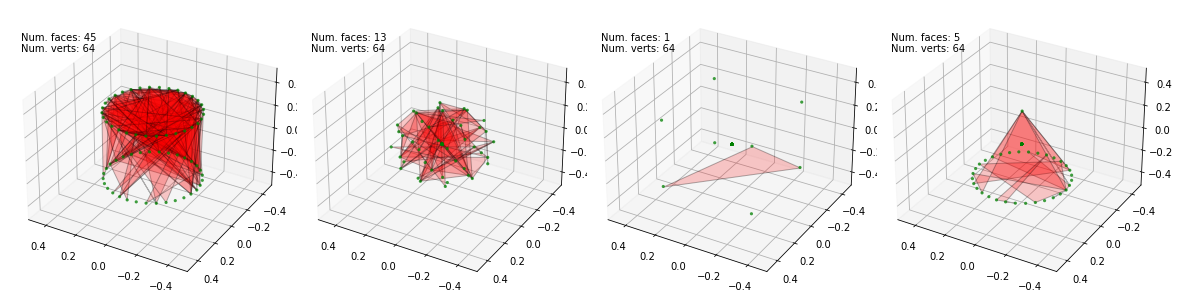

Epoch 100: Face Loss = 2193.5283203125


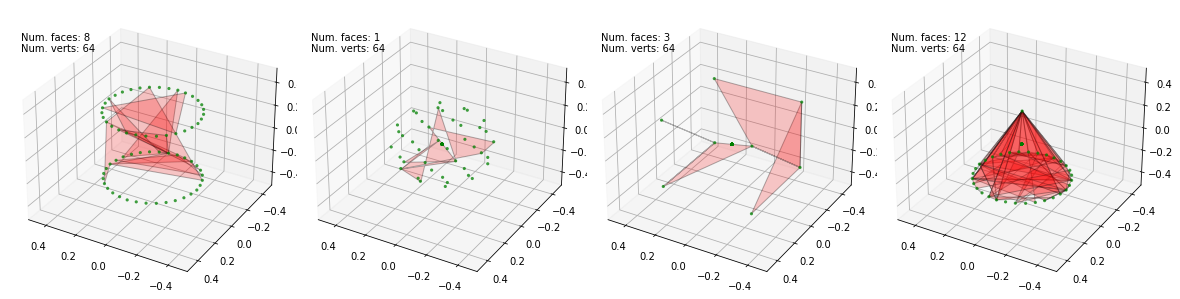

Epoch 150: Face Loss = 1172.076171875


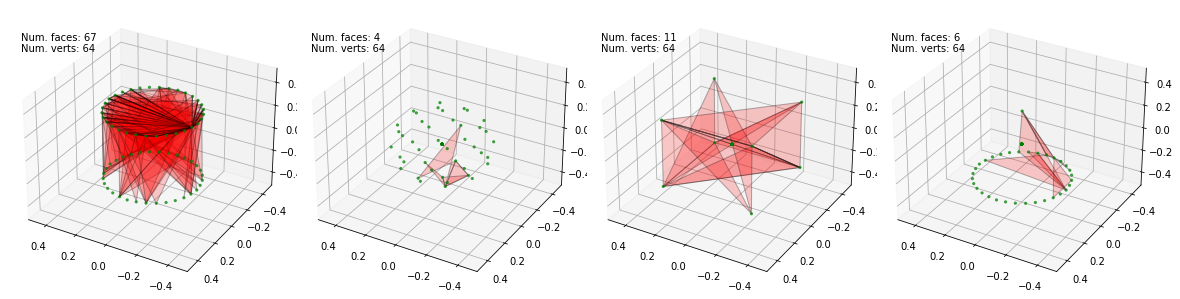

Epoch 200: Face Loss = 399.9056701660156


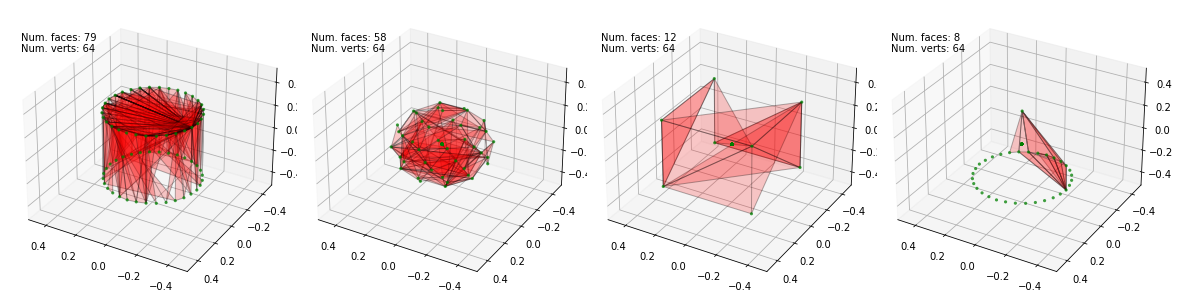

Epoch 250: Face Loss = 115.78990173339844


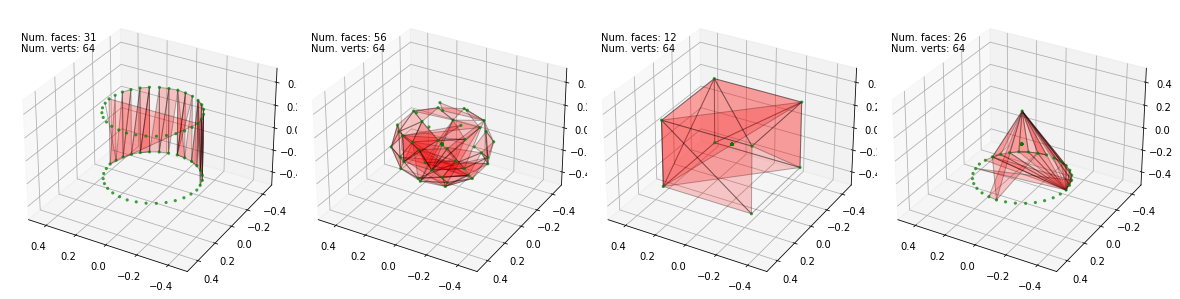

Epoch 300: Face Loss = 38.79916000366211


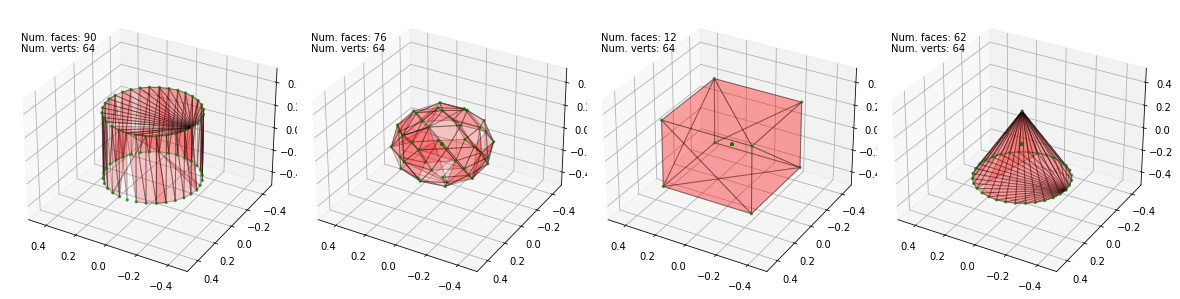

Epoch 350: Face Loss = 19.4145450592041


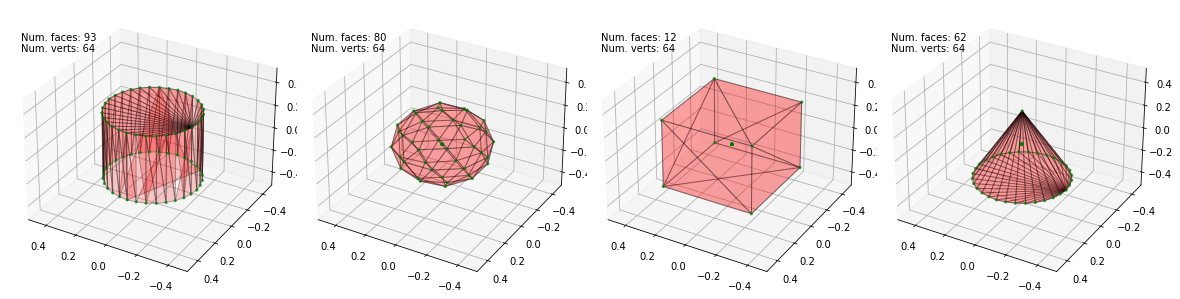

Epoch 400: Face Loss = 13.448003768920898


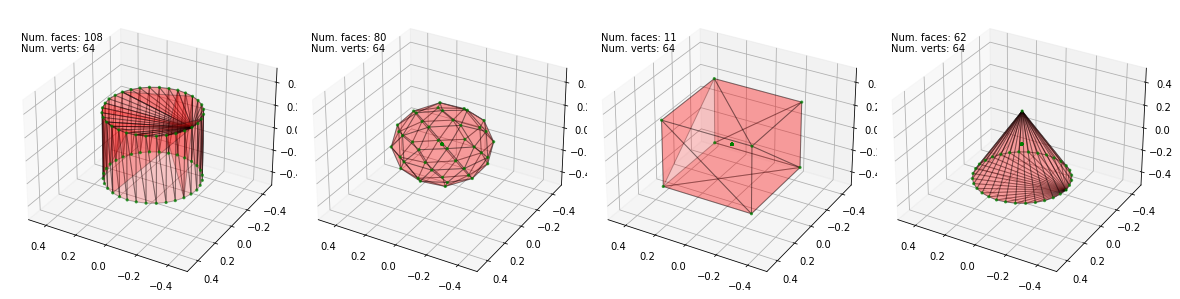

Epoch 450: Face Loss = 9.749460220336914


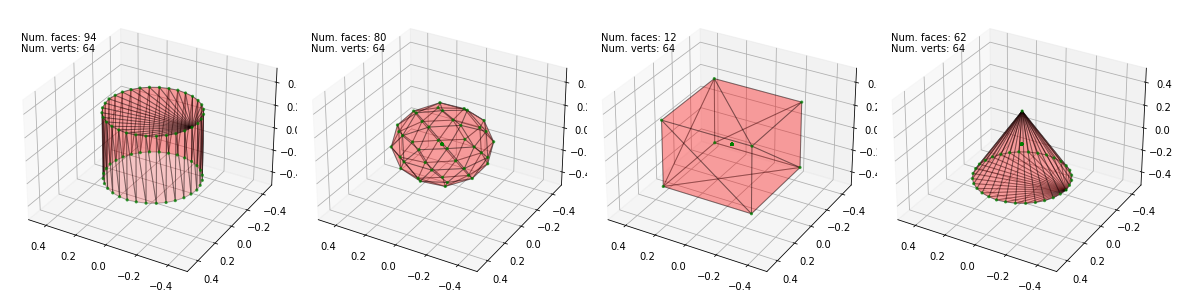

Epoch 500: Face Loss = 7.003475666046143


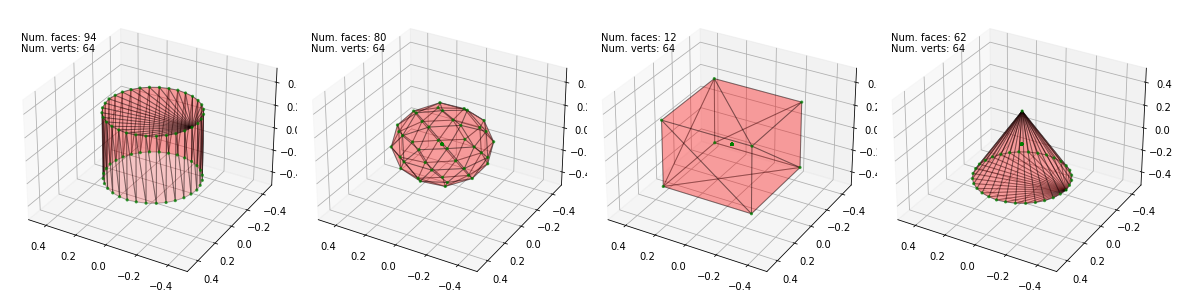

In [10]:
"""Train Face Model"""
epochs = 500
face_model_optimizer = face_model.configure_optimizers()["optimizer"]
for i in range(epochs):
    face_model_optimizer.zero_grad()
    face_logits = face_model(face_batch)
    face_pred_dist = torch.distributions.categorical.Categorical(logits = face_logits)
    face_loss = -torch.sum(face_pred_dist.log_prob(face_batch["faces"])* face_batch["faces_mask"])
    face_loss.backward()
    face_model_optimizer.step()

    if (i + 1) % 50 == 0:
        print(f"Epoch {i + 1}: Face Loss = {face_loss.item()}")
        sample_and_plot_faces(face_model, face_batch)